In [ ]:
# Install dependencies
!pip install timm einops omegaconf

# Clone Apple's CVNets repository (includes MobileViT)
!git clone https://github.com/apple/ml-cvnets.git
%cd ml-cvnets
!pip install -r requirements.txt -c constraints.txt
!pip install --editable .

# Go back to root dir to avoid path conflicts
%cd ..

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## Load Dataset Code by sir

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# === PARAMETERS ===
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 1
NUM_CLASSES = 5  # 5 emotion categories
LEARNING_RATE = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = ['F', 'H', 'Sad', 'S', 'N']
# === DATASET CLASS ===
class SpectrogramDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform
        self.file_names = self.df['file_name'].values
        self.labels = (self.df['label'] - 1).values  # Convert 1-5 to 0-4

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.file_names[idx])
        image = Image.open(img_path).convert("RGB")

        img_array = np.array(image)
        height, width = img_array.shape[:2]
        left_half = img_array[:, :width//2, :]
        right_half = img_array[:, width//2:, :]
        combined_img = np.vstack((left_half, right_half))
        combined_img = Image.fromarray(combined_img)

        label = self.labels[idx]

        if self.transform:
            combined_img = self.transform(combined_img)

        return combined_img, label, self.file_names[idx]  # Now returning filename too

    def get_labels(self):
        return self.labels

# Load later
#train_dataset = torch.load('train_dataset.pt')
#val_dataset = torch.load('val_dataset.pt')
#test_dataset = torch.load('test_dataset.pt')
# Create data loaders
#train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#print(f"Training set size: {len(train_dataset)}")
#print(f"Validation set size: {len(val_dataset)}")
#print(f"Test set size: {len(test_dataset)}")

def load_full_dataset(filename):
    data = torch.load(filename)
    return data['images'], data['labels'], data['filenames']

# Example usage:
train_images, train_labels, train_filenames = load_full_dataset('/content/train_dataset_full.pt')
val_images, val_labels, val_filenames = load_full_dataset('/content/val_dataset_full.pt')
test_images, test_labels, test_filenames = load_full_dataset('/content/test_dataset_full.pt')


## MobileViT Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR

# === PARAMETERS ===
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 75
NUM_CLASSES = 5
LEARNING_RATE = 1e-3
PATIENCE = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = ['F', 'H', 'Sad', 'S', 'N']

# === DATA AUGMENTATION ===
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# === WRAPPER DATASET ===
class TensorImageDataset(Dataset):
    def __init__(self, images, labels, filenames, transform=None):
        self.images = images
        self.labels = labels
        self.filenames = filenames
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx], self.filenames[idx]

# === LOAD DATA ===
def load_full_dataset(filename):
    data = torch.load(filename)
    return data['images'], data['labels'], data['filenames']

train_images, train_labels, train_filenames = load_full_dataset('/content/train_dataset_full.pt')
val_images, val_labels, val_filenames = load_full_dataset('/content/val_dataset_full.pt')
test_images, test_labels, test_filenames = load_full_dataset('/content/test_dataset_full.pt')

train_dataset = TensorImageDataset(train_images, train_labels, train_filenames, transform=train_transform)
val_dataset = TensorImageDataset(val_images, val_labels, val_filenames, transform=val_test_transform)
test_dataset = TensorImageDataset(test_images, test_labels, test_filenames, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# === MODEL ===
model = timm.create_model('mobilevit_s', pretrained=True, num_classes=NUM_CLASSES,
                         drop_rate=0.2, drop_path_rate=0.1)


# Replace the final FC layer with:
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Add dropout
    nn.Linear(512, 256),  # Smaller intermediate layer
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, NUM_CLASSES)
)

# Freeze layers
for name, param in model.named_parameters():
    if 'stages.0' in name or 'stages.1' in name or 'stages.2' in name:
        param.requires_grad = False


# Replace the classification head with a trainable one
in_features = model.get_classifier().in_features
model.reset_classifier(num_classes=NUM_CLASSES)  # resets the head
for param in model.get_classifier().parameters():
    param.requires_grad = True  # unfreeze only the head

model.to(device)

# === LOSS, OPTIMIZER, SCHEDULER ===
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# Only optimize the head
# Collect parameter groups with different learning rates
head_params = []
backbone_params = []

for name, param in model.named_parameters():
    if param.requires_grad:
        if 'fc' in name:
            head_params.append(param)
        else:
            backbone_params.append(param)

# Use different learning rates
# Update optimizer initialization
optimizer = optim.AdamW([
    {'params': backbone_params, 'lr': 1e-6, 'weight_decay': 1e-5},
    {'params': head_params, 'lr': 1e-4, 'weight_decay': 1e-4}
])

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# === TRAINING & VALIDATION ===
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct = 0, 0
    for imgs, labels, _ in tqdm(loader, desc="Training"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels, _ in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return total_loss / len(loader), correct / len(loader.dataset), all_preds, all_labels

# === TRAIN LOOP ===
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    if epoch == 40:  # Unfreeze after 10 epochs
      for name, param in model.named_parameters():
        if 'stages.2' in name:
          param.requires_grad = False
    if epoch == 46:  # Unfreeze after 10 epochs
      for name, param in model.named_parameters():
        if 'stages.1' in name or 'stages.2' in name:
          param.requires_grad = False
    if epoch == 52:  # Unfreeze after 10 epochs
      for name, param in model.named_parameters():
        if 'stages.0' in name or 'stages.1' in name or 'stages.2' in name:
          param.requires_grad = False

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_mobilevit.pth')
        patience_counter = 0
        print("✅ Saved best model")



Epoch 1/75


Training: 100%|██████████| 41/41 [00:07<00:00,  5.34it/s]


Train Loss: 1.6193 | Acc: 0.2178
Val   Loss: 1.6184 | Acc: 0.1358
✅ Saved best model

Epoch 2/75


Training: 100%|██████████| 41/41 [00:07<00:00,  5.15it/s]


Train Loss: 1.6095 | Acc: 0.2132
Val   Loss: 1.6236 | Acc: 0.1605

Epoch 3/75


Training: 100%|██████████| 41/41 [00:07<00:00,  5.27it/s]


Train Loss: 1.6069 | Acc: 0.2009
Val   Loss: 1.6160 | Acc: 0.1728
✅ Saved best model

Epoch 4/75


Training: 100%|██████████| 41/41 [00:06<00:00,  6.06it/s]


Train Loss: 1.6024 | Acc: 0.2025
Val   Loss: 1.6079 | Acc: 0.2099
✅ Saved best model

Epoch 5/75


Training: 100%|██████████| 41/41 [00:08<00:00,  5.08it/s]


Train Loss: 1.6087 | Acc: 0.2377
Val   Loss: 1.6066 | Acc: 0.2222
✅ Saved best model

Epoch 6/75


Training: 100%|██████████| 41/41 [00:07<00:00,  5.85it/s]


Train Loss: 1.5905 | Acc: 0.2653
Val   Loss: 1.6024 | Acc: 0.2346
✅ Saved best model

Epoch 7/75


Training: 100%|██████████| 41/41 [00:07<00:00,  5.43it/s]


Train Loss: 1.6055 | Acc: 0.2316
Val   Loss: 1.6069 | Acc: 0.2346

Epoch 8/75


Training: 100%|██████████| 41/41 [00:07<00:00,  5.18it/s]


Train Loss: 1.5965 | Acc: 0.2485
Val   Loss: 1.6011 | Acc: 0.2469
✅ Saved best model

Epoch 9/75


Training: 100%|██████████| 41/41 [00:06<00:00,  5.88it/s]


Train Loss: 1.5983 | Acc: 0.2224
Val   Loss: 1.5901 | Acc: 0.2346
✅ Saved best model

Epoch 10/75


Training: 100%|██████████| 41/41 [00:07<00:00,  5.20it/s]


Train Loss: 1.5938 | Acc: 0.2377
Val   Loss: 1.5965 | Acc: 0.2222

Epoch 11/75


Training: 100%|██████████| 41/41 [00:07<00:00,  5.32it/s]


Train Loss: 1.5940 | Acc: 0.2638
Val   Loss: 1.5871 | Acc: 0.2346
✅ Saved best model

Epoch 12/75


Training: 100%|██████████| 41/41 [00:06<00:00,  5.96it/s]


Train Loss: 1.5875 | Acc: 0.2822
Val   Loss: 1.5811 | Acc: 0.2593
✅ Saved best model

Epoch 13/75


Training: 100%|██████████| 41/41 [00:07<00:00,  5.15it/s]


Train Loss: 1.5960 | Acc: 0.2408
Val   Loss: 1.5790 | Acc: 0.2593
✅ Saved best model

Epoch 14/75


Training: 100%|██████████| 41/41 [00:08<00:00,  4.58it/s]


Train Loss: 1.5923 | Acc: 0.2561
Val   Loss: 1.5721 | Acc: 0.2469
✅ Saved best model

Epoch 15/75


Training: 100%|██████████| 41/41 [00:06<00:00,  6.00it/s]


Train Loss: 1.5866 | Acc: 0.2653
Val   Loss: 1.5671 | Acc: 0.2716
✅ Saved best model

Epoch 16/75


Training: 100%|██████████| 41/41 [00:08<00:00,  4.78it/s]


Train Loss: 1.5884 | Acc: 0.2546
Val   Loss: 1.5726 | Acc: 0.2593

Epoch 17/75


Training: 100%|██████████| 41/41 [00:08<00:00,  5.07it/s]


Train Loss: 1.5808 | Acc: 0.2607
Val   Loss: 1.5744 | Acc: 0.2346

Epoch 18/75


Training: 100%|██████████| 41/41 [00:07<00:00,  5.49it/s]


Train Loss: 1.5724 | Acc: 0.2669
Val   Loss: 1.5696 | Acc: 0.2716

Epoch 19/75


Training: 100%|██████████| 41/41 [00:08<00:00,  4.72it/s]


Train Loss: 1.5748 | Acc: 0.2638
Val   Loss: 1.5616 | Acc: 0.2346
✅ Saved best model

Epoch 20/75


Training: 100%|██████████| 41/41 [00:08<00:00,  5.12it/s]


Train Loss: 1.5764 | Acc: 0.2730
Val   Loss: 1.5506 | Acc: 0.2593
✅ Saved best model

Epoch 21/75


Training: 100%|██████████| 41/41 [00:06<00:00,  5.88it/s]


Train Loss: 1.5768 | Acc: 0.2623
Val   Loss: 1.5392 | Acc: 0.2840
✅ Saved best model

Epoch 22/75


Training: 100%|██████████| 41/41 [00:07<00:00,  5.15it/s]


Train Loss: 1.5689 | Acc: 0.2745
Val   Loss: 1.5346 | Acc: 0.2346
✅ Saved best model

Epoch 23/75


Training: 100%|██████████| 41/41 [00:07<00:00,  5.52it/s]


Train Loss: 1.5757 | Acc: 0.2776
Val   Loss: 1.5424 | Acc: 0.2593

Epoch 24/75


Training: 100%|██████████| 41/41 [00:07<00:00,  5.59it/s]


Train Loss: 1.5712 | Acc: 0.2807
Val   Loss: 1.5381 | Acc: 0.2099

Epoch 25/75


Training: 100%|██████████| 41/41 [00:08<00:00,  5.11it/s]


Train Loss: 1.5634 | Acc: 0.2822
Val   Loss: 1.5397 | Acc: 0.2716

Epoch 26/75


Training: 100%|██████████| 41/41 [00:07<00:00,  5.85it/s]


Train Loss: 1.5613 | Acc: 0.2745
Val   Loss: 1.5424 | Acc: 0.3086

Epoch 27/75


Training: 100%|██████████| 41/41 [00:10<00:00,  4.06it/s]


Train Loss: 1.5480 | Acc: 0.3083
Val   Loss: 1.5366 | Acc: 0.3210

Epoch 28/75


Training: 100%|██████████| 41/41 [00:10<00:00,  3.79it/s]


Train Loss: 1.5585 | Acc: 0.2807
Val   Loss: 1.5454 | Acc: 0.2840

Epoch 29/75


Training: 100%|██████████| 41/41 [00:11<00:00,  3.67it/s]


Train Loss: 1.5698 | Acc: 0.2546
Val   Loss: 1.5337 | Acc: 0.3580
✅ Saved best model

Epoch 30/75


Training: 100%|██████████| 41/41 [00:10<00:00,  3.88it/s]


Train Loss: 1.5427 | Acc: 0.3129
Val   Loss: 1.5420 | Acc: 0.3333

Epoch 31/75


Training: 100%|██████████| 41/41 [00:08<00:00,  4.68it/s]


Train Loss: 1.5373 | Acc: 0.3390
Val   Loss: 1.5311 | Acc: 0.3580
✅ Saved best model

Epoch 32/75


Training: 100%|██████████| 41/41 [00:09<00:00,  4.41it/s]


Train Loss: 1.5740 | Acc: 0.2592
Val   Loss: 1.5352 | Acc: 0.3580

Epoch 33/75


Training: 100%|██████████| 41/41 [00:10<00:00,  3.73it/s]


Train Loss: 1.5453 | Acc: 0.2807
Val   Loss: 1.5342 | Acc: 0.3333

Epoch 34/75


Training: 100%|██████████| 41/41 [00:10<00:00,  3.95it/s]


Train Loss: 1.5413 | Acc: 0.3006
Val   Loss: 1.5339 | Acc: 0.3580

Epoch 35/75


Training: 100%|██████████| 41/41 [00:10<00:00,  4.09it/s]


Train Loss: 1.5417 | Acc: 0.3067
Val   Loss: 1.5321 | Acc: 0.3457

Epoch 36/75


Training: 100%|██████████| 41/41 [00:10<00:00,  4.06it/s]


Train Loss: 1.5460 | Acc: 0.2929
Val   Loss: 1.5429 | Acc: 0.3333

Epoch 37/75


Training: 100%|██████████| 41/41 [00:11<00:00,  3.54it/s]


Train Loss: 1.5452 | Acc: 0.3098
Val   Loss: 1.5358 | Acc: 0.3580

Epoch 38/75


Training: 100%|██████████| 41/41 [00:11<00:00,  3.59it/s]


Train Loss: 1.5552 | Acc: 0.2791
Val   Loss: 1.5254 | Acc: 0.3333
✅ Saved best model

Epoch 39/75


Training: 100%|██████████| 41/41 [00:08<00:00,  4.56it/s]


Train Loss: 1.5564 | Acc: 0.2837
Val   Loss: 1.5416 | Acc: 0.3457

Epoch 40/75


Training: 100%|██████████| 41/41 [00:08<00:00,  4.60it/s]


Train Loss: 1.5658 | Acc: 0.2914
Val   Loss: 1.5360 | Acc: 0.3333

Epoch 41/75


Training: 100%|██████████| 41/41 [00:10<00:00,  3.91it/s]


Train Loss: 1.5457 | Acc: 0.3052
Val   Loss: 1.5371 | Acc: 0.3333

Epoch 42/75


Training: 100%|██████████| 41/41 [00:10<00:00,  3.86it/s]


Train Loss: 1.5427 | Acc: 0.2975
Val   Loss: 1.5319 | Acc: 0.3457

Epoch 43/75


Training: 100%|██████████| 41/41 [00:08<00:00,  4.92it/s]


Train Loss: 1.5414 | Acc: 0.2945
Val   Loss: 1.5381 | Acc: 0.3457

Epoch 44/75


Training: 100%|██████████| 41/41 [00:07<00:00,  5.72it/s]


Train Loss: 1.5558 | Acc: 0.2807
Val   Loss: 1.5320 | Acc: 0.3580

Epoch 45/75


Training: 100%|██████████| 41/41 [00:08<00:00,  4.89it/s]


Train Loss: 1.5529 | Acc: 0.3006
Val   Loss: 1.5442 | Acc: 0.3210

Epoch 46/75


Training: 100%|██████████| 41/41 [00:08<00:00,  5.00it/s]


Train Loss: 1.5340 | Acc: 0.3006
Val   Loss: 1.5332 | Acc: 0.3580

Epoch 47/75


Training: 100%|██████████| 41/41 [00:07<00:00,  5.74it/s]


Train Loss: 1.5409 | Acc: 0.3037
Val   Loss: 1.5313 | Acc: 0.3457

Epoch 48/75


Training: 100%|██████████| 41/41 [00:08<00:00,  5.03it/s]


Train Loss: 1.5483 | Acc: 0.2791
Val   Loss: 1.5246 | Acc: 0.3457
✅ Saved best model

Epoch 49/75


Training: 100%|██████████| 41/41 [00:08<00:00,  5.07it/s]


Train Loss: 1.5405 | Acc: 0.3160
Val   Loss: 1.5214 | Acc: 0.3580
✅ Saved best model

Epoch 50/75


Training: 100%|██████████| 41/41 [00:07<00:00,  5.13it/s]


Train Loss: 1.5382 | Acc: 0.2868
Val   Loss: 1.5371 | Acc: 0.3333

Epoch 51/75


Training: 100%|██████████| 41/41 [00:09<00:00,  4.55it/s]


Train Loss: 1.5292 | Acc: 0.3328
Val   Loss: 1.5355 | Acc: 0.3333

Epoch 52/75


Training: 100%|██████████| 41/41 [00:08<00:00,  5.01it/s]


Train Loss: 1.5558 | Acc: 0.2822
Val   Loss: 1.5233 | Acc: 0.3457

Epoch 53/75


Training: 100%|██████████| 41/41 [00:07<00:00,  5.81it/s]


Train Loss: 1.5555 | Acc: 0.2684
Val   Loss: 1.5362 | Acc: 0.3457

Epoch 54/75


Training: 100%|██████████| 41/41 [00:08<00:00,  4.64it/s]


Train Loss: 1.5496 | Acc: 0.2791
Val   Loss: 1.5355 | Acc: 0.3457

Epoch 55/75


Training: 100%|██████████| 41/41 [00:08<00:00,  4.93it/s]


Train Loss: 1.5247 | Acc: 0.3083
Val   Loss: 1.5381 | Acc: 0.3333

Epoch 56/75


Training: 100%|██████████| 41/41 [00:07<00:00,  5.74it/s]


Train Loss: 1.5360 | Acc: 0.2914
Val   Loss: 1.5375 | Acc: 0.3333

Epoch 57/75


Training: 100%|██████████| 41/41 [00:08<00:00,  5.04it/s]


Train Loss: 1.5419 | Acc: 0.3098
Val   Loss: 1.5383 | Acc: 0.3333

Epoch 58/75


Training: 100%|██████████| 41/41 [00:08<00:00,  4.96it/s]


Train Loss: 1.5477 | Acc: 0.2975
Val   Loss: 1.5403 | Acc: 0.3580

Epoch 59/75


Training: 100%|██████████| 41/41 [00:07<00:00,  5.66it/s]


Train Loss: 1.5394 | Acc: 0.3006
Val   Loss: 1.5269 | Acc: 0.3333

Epoch 60/75


Training: 100%|██████████| 41/41 [00:08<00:00,  4.93it/s]


Train Loss: 1.5193 | Acc: 0.3298
Val   Loss: 1.5419 | Acc: 0.3457

Epoch 61/75


Training: 100%|██████████| 41/41 [00:08<00:00,  5.09it/s]


Train Loss: 1.5495 | Acc: 0.3067
Val   Loss: 1.5355 | Acc: 0.3457

Epoch 62/75


Training: 100%|██████████| 41/41 [00:09<00:00,  4.36it/s]


Train Loss: 1.5403 | Acc: 0.3190
Val   Loss: 1.5318 | Acc: 0.3457

Epoch 63/75


Training: 100%|██████████| 41/41 [00:07<00:00,  5.16it/s]


Train Loss: 1.5412 | Acc: 0.3021
Val   Loss: 1.5260 | Acc: 0.3210

Epoch 64/75


Training: 100%|██████████| 41/41 [00:08<00:00,  4.97it/s]


Train Loss: 1.5496 | Acc: 0.2638
Val   Loss: 1.5395 | Acc: 0.3333

Epoch 65/75


Training: 100%|██████████| 41/41 [00:07<00:00,  5.77it/s]


Train Loss: 1.5499 | Acc: 0.2761
Val   Loss: 1.5257 | Acc: 0.3580

Epoch 66/75


Training: 100%|██████████| 41/41 [00:08<00:00,  4.88it/s]


Train Loss: 1.5533 | Acc: 0.2745
Val   Loss: 1.5370 | Acc: 0.3457

Epoch 67/75


Training: 100%|██████████| 41/41 [00:08<00:00,  4.97it/s]


Train Loss: 1.5505 | Acc: 0.3006
Val   Loss: 1.5344 | Acc: 0.3580

Epoch 68/75


Training: 100%|██████████| 41/41 [00:07<00:00,  5.82it/s]


Train Loss: 1.5447 | Acc: 0.2991
Val   Loss: 1.5317 | Acc: 0.3457

Epoch 69/75


Training: 100%|██████████| 41/41 [00:08<00:00,  4.98it/s]


Train Loss: 1.5470 | Acc: 0.3144
Val   Loss: 1.5238 | Acc: 0.3457

Epoch 70/75


Training: 100%|██████████| 41/41 [00:08<00:00,  4.95it/s]


Train Loss: 1.5479 | Acc: 0.3129
Val   Loss: 1.5239 | Acc: 0.3333

Epoch 71/75


Training: 100%|██████████| 41/41 [00:07<00:00,  5.72it/s]


Train Loss: 1.5445 | Acc: 0.3098
Val   Loss: 1.5278 | Acc: 0.3457

Epoch 72/75


Training: 100%|██████████| 41/41 [00:08<00:00,  4.89it/s]


Train Loss: 1.5311 | Acc: 0.3221
Val   Loss: 1.5311 | Acc: 0.3210

Epoch 73/75


Training: 100%|██████████| 41/41 [00:08<00:00,  4.97it/s]


Train Loss: 1.5516 | Acc: 0.3083
Val   Loss: 1.5256 | Acc: 0.3457

Epoch 74/75


Training: 100%|██████████| 41/41 [00:07<00:00,  5.68it/s]


Train Loss: 1.5485 | Acc: 0.2914
Val   Loss: 1.5342 | Acc: 0.3580

Epoch 75/75


Training: 100%|██████████| 41/41 [00:08<00:00,  4.61it/s]


Train Loss: 1.5417 | Acc: 0.3221
Val   Loss: 1.5358 | Acc: 0.3333


## Testing

In [ ]:
# === TEST EVALUATION ===
_, test_acc, test_preds, test_labels_np = evaluate(model, test_loader, criterion)
print(f"\n🧪 Test Accuracy of latest model: {test_acc:.4f}")
torch.save(model.state_dict(), 'latest_mobilevit.pth')

model.load_state_dict(torch.load('best_mobilevit.pth'))
_, test_acc, test_preds, test_labels_np = evaluate(model, test_loader, criterion)
print(f"\n🧪 Test Accuracy of best model: {test_acc:.4f}")


🧪 Test baoo Accuracy of latest model: 0.4146

🧪 Test Accuracy of best model: 0.3293


## Confusion Matrix


🧪 Test Accuracy of best model: 0.4146

Multi-class Confusion Matrix:
     F  H  Sad  S   N
F    3  3    2  5   3
H    2  7    1  0   7
Sad  2  3    1  4   6
S    0  7    0  7   2
N    0  1    0  0  16


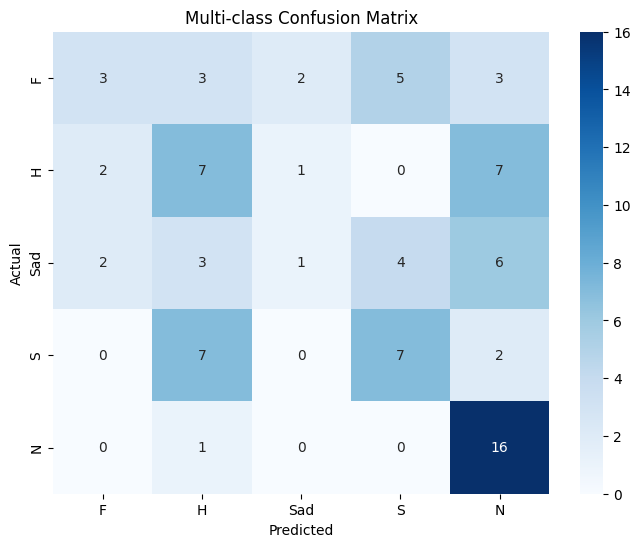

In [ ]:
model.load_state_dict(torch.load('latest_mobilevit.pth'))
_, test_acc, test_preds, test_labels_np = evaluate(model, test_loader, criterion)
print(f"\n🧪 Test Accuracy of best model: {test_acc:.4f}")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
# === CONFUSION MATRIX ===
cm_multi = confusion_matrix(test_labels_np, test_preds)
cm_multi_df = pd.DataFrame(cm_multi, index=classes, columns=classes)
print("\nMulti-class Confusion Matrix:")
print(cm_multi_df)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Multi-class Confusion Matrix')
plt.show()

## Classification Report

In [ ]:
# === CLASSIFICATION REPORT ===
print("\nDetailed Classification Report:")
print(classification_report(test_labels_np, test_preds, target_names=classes))

# === CLASS-WISE ACCURACY ===
class_accuracy = cm_multi.diagonal() / cm_multi.sum(axis=1)
print("\nClass-wise Accuracy:")
for class_name, acc in zip(classes, class_accuracy):
    print(f"{class_name}: {acc:.2%}")  # Format as percentage

# Optional: Create a combined metrics dataframe
report = classification_report(test_labels_np, test_preds, target_names=classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df['accuracy'] = None  # Add empty column
report_df.loc[classes, 'accuracy'] = class_accuracy  # Fill class accuracies

print("\nCombined Metrics Report:")
print(report_df)


Detailed Classification Report:
              precision    recall  f1-score   support

           F       0.43      0.19      0.26        16
           H       0.33      0.41      0.37        17
         Sad       0.25      0.06      0.10        16
           S       0.44      0.44      0.44        16
           N       0.47      0.94      0.63        17

    accuracy                           0.41        82
   macro avg       0.38      0.41      0.36        82
weighted avg       0.38      0.41      0.36        82


Class-wise Accuracy:
F: 18.75%
H: 41.18%
Sad: 6.25%
S: 43.75%
N: 94.12%

Combined Metrics Report:
              precision    recall  f1-score    support  accuracy
F              0.428571  0.187500  0.260870  16.000000    0.1875
H              0.333333  0.411765  0.368421  17.000000  0.411765
Sad            0.250000  0.062500  0.100000  16.000000    0.0625
S              0.437500  0.437500  0.437500  16.000000    0.4375
N              0.470588  0.941176  0.627451  17.000000

## Accuracy and loss Graphs

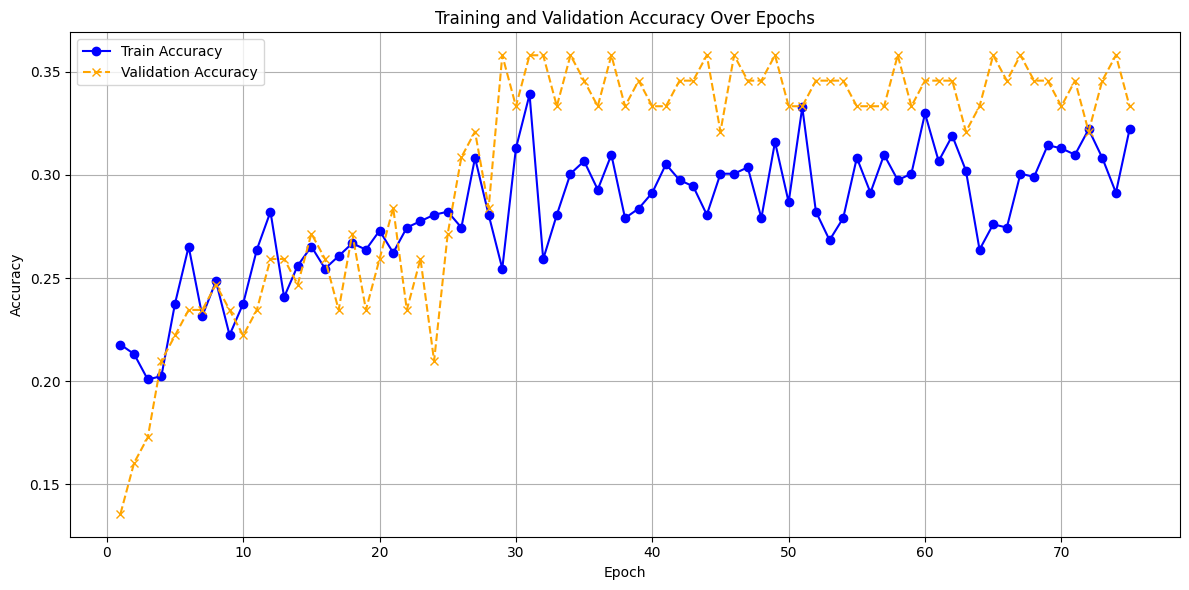

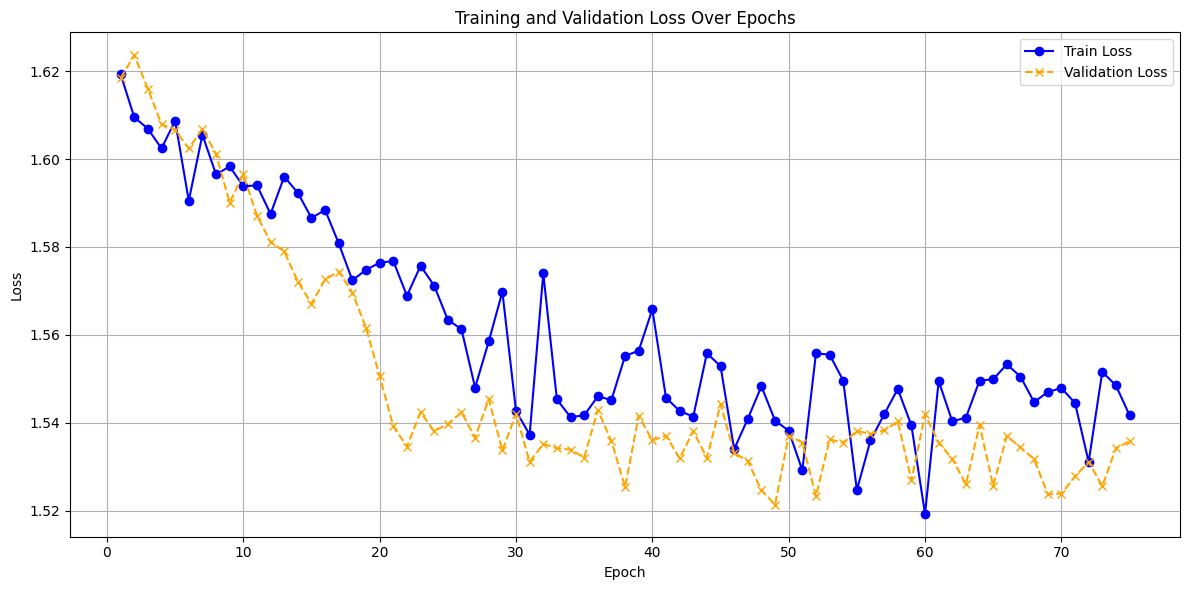

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 76))  # Epoch numbers (1-75)

train_loss = [
    1.6193, 1.6095, 1.6069, 1.6024, 1.6087, 1.5905, 1.6055, 1.5965, 1.5983, 1.5938,
    1.5940, 1.5875, 1.5960, 1.5923, 1.5866, 1.5884, 1.5808, 1.5724, 1.5748, 1.5764,
    1.5768, 1.5689, 1.5757, 1.5712, 1.5634, 1.5613, 1.5480, 1.5585, 1.5698, 1.5427,
    1.5373, 1.5740, 1.5453, 1.5413, 1.5417, 1.5460, 1.5452, 1.5552, 1.5564, 1.5658,
    1.5457, 1.5427, 1.5414, 1.5558, 1.5529, 1.5340, 1.5409, 1.5483, 1.5405, 1.5382,
    1.5292, 1.5558, 1.5555, 1.5496, 1.5247, 1.5360, 1.5419, 1.5477, 1.5394, 1.5193,
    1.5495, 1.5403, 1.5412, 1.5496, 1.5499, 1.5533, 1.5505, 1.5447, 1.5470, 1.5479,
    1.5445, 1.5311, 1.5516, 1.5485, 1.5417
]

train_acc = [
    0.2178, 0.2132, 0.2009, 0.2025, 0.2377, 0.2653, 0.2316, 0.2485, 0.2224, 0.2377,
    0.2638, 0.2822, 0.2408, 0.2561, 0.2653, 0.2546, 0.2607, 0.2669, 0.2638, 0.2730,
    0.2623, 0.2745, 0.2776, 0.2807, 0.2822, 0.2745, 0.3083, 0.2807, 0.2546, 0.3129,
    0.3390, 0.2592, 0.2807, 0.3006, 0.3067, 0.2929, 0.3098, 0.2791, 0.2837, 0.2914,
    0.3052, 0.2975, 0.2945, 0.2807, 0.3006, 0.3006, 0.3037, 0.2791, 0.3160, 0.2868,
    0.3328, 0.2822, 0.2684, 0.2791, 0.3083, 0.2914, 0.3098, 0.2975, 0.3006, 0.3298,
    0.3067, 0.3190, 0.3021, 0.2638, 0.2761, 0.2745, 0.3006, 0.2991, 0.3144, 0.3129,
    0.3098, 0.3221, 0.3083, 0.2914, 0.3221
]

val_loss = [
    1.6184, 1.6236, 1.6160, 1.6079, 1.6066, 1.6024, 1.6069, 1.6011, 1.5901, 1.5965,
    1.5871, 1.5811, 1.5790, 1.5721, 1.5671, 1.5726, 1.5744, 1.5696, 1.5616, 1.5506,
    1.5392, 1.5346, 1.5424, 1.5381, 1.5397, 1.5424, 1.5366, 1.5454, 1.5337, 1.5420,
    1.5311, 1.5352, 1.5342, 1.5339, 1.5321, 1.5429, 1.5358, 1.5254, 1.5416, 1.5360,
    1.5371, 1.5319, 1.5381, 1.5320, 1.5442, 1.5332, 1.5313, 1.5246, 1.5214, 1.5371,
    1.5355, 1.5233, 1.5362, 1.5355, 1.5381, 1.5375, 1.5383, 1.5403, 1.5269, 1.5419,
    1.5355, 1.5318, 1.5260, 1.5395, 1.5257, 1.5370, 1.5344, 1.5317, 1.5238, 1.5239,
    1.5278, 1.5311, 1.5256, 1.5342, 1.5358
]

val_acc = [
    0.1358, 0.1605, 0.1728, 0.2099, 0.2222, 0.2346, 0.2346, 0.2469, 0.2346, 0.2222,
    0.2346, 0.2593, 0.2593, 0.2469, 0.2716, 0.2593, 0.2346, 0.2716, 0.2346, 0.2593,
    0.2840, 0.2346, 0.2593, 0.2099, 0.2716, 0.3086, 0.3210, 0.2840, 0.3580, 0.3333,
    0.3580, 0.3580, 0.3333, 0.3580, 0.3457, 0.3333, 0.3580, 0.3333, 0.3457, 0.3333,
    0.3333, 0.3457, 0.3457, 0.3580, 0.3210, 0.3580, 0.3457, 0.3457, 0.3580, 0.3333,
    0.3333, 0.3457, 0.3457, 0.3457, 0.3333, 0.3333, 0.3333, 0.3580, 0.3333, 0.3457,
    0.3457, 0.3457, 0.3210, 0.3333, 0.3580, 0.3457, 0.3580, 0.3457, 0.3457, 0.3333,
    0.3457, 0.3210, 0.3457, 0.3580, 0.3333
]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Train Accuracy', color='blue', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', linestyle='--', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Train Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange', linestyle='--', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
